# Decision Trees & Model Evaluation

### Contributors
Professor Foster Provost - NYU Stern School of Business and Carlos Fernandez - teaching assistant

References: 
- Documentation scikit-learn (http://scikit-learn.org/stable/documentation.html)
- Introduction to Machine Learning with Python (http://shop.oreilly.com/product/0636920030515.do)

In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

In [3]:
# Load data
path = "./data/titanic.csv"
df = pd.read_csv(path)[["survived", "pclass", "sex", "age", "fare"]].dropna()
df['survive'] = df.survived.astype(bool)
df.head()

,survived,pclass,sex,age,fare,survive
0,1.0,1.0,female,29.0000,211.3375,True
1,1.0,1.0,male,0.9167,151.5500,True
2,0.0,1.0,female,2.0000,151.5500,False
3,0.0,1.0,male,30.0000,151.5500,False
4,0.0,1.0,female,25.0000,151.5500,False


In [4]:
# create a copy of df and call it df2 so that we can make some transformations and still keep df
df2 = df.copy()
# Transform sex column to a numeric variable
df2["female"] = (df2.sex == "female").astype(int)
df2 = df2.drop("sex", axis="columns")
# Drop outliers. This is to help the visualization in the next examples.
df2 = df2[df2.fare < 400]
# Take a look at the data
df2.head(5)

,survived,pclass,age,fare,survive,female
0,1.0,1.0,29.0000,211.3375,True,1
1,1.0,1.0,0.9167,151.5500,True,0
2,0.0,1.0,2.0000,151.5500,False,1
3,0.0,1.0,30.0000,151.5500,False,0
4,0.0,1.0,25.0000,151.5500,False,1


### Entropy & Information Gain

***


**Entropy** ($H$) and **information gain** ($IG$) au useful tools for measuring the effectiveness of a split on the data. Entropy measures how random data is, information gain is a measure of the reduction in randomness after performing a split.

<table style="border: 0px">
<tr style="border: 0px">
<td style="border: 0px"><img src="images/dsfb_0304.png" height=80% width=80%>
Figure 3-4. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</td>
<td style="border: 0px; width: 30px"></td>
<td style="border: 0px"><img src="images/dsfb_0305.png" height=75% width=75%>
Figure 3-5. A classification tree split on the three-values Residence attribute.</td>
</tr>
</table>

Given the data, it is fairly straight forward to calculate both of these quantities.

#### Functions to get the entropy and IG
__Using df__

In [26]:
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()  
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot 

Now that we have a way of calculating $H$ and $IG$, let's test the hunch that using 50 as a split on fare allows us to determine if someone will survive.

In [27]:
threshold = 50
prior_entropy = entropy(df["survive"])
IG = information_gain(df, "fare", "survive", threshold)
print ("IG of %.4f using a threshold of %.2f given a prior entropy of %.4f" % (IG, threshold, prior_entropy))

IG of 0.0581 using a threshold of 50.00 given a prior entropy of 0.9758


How good was our guess of 50? Let's loop through all possible splits on fare and see what is the best!

In [28]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0

    for thresh in df[info_column]:
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh
            
    return (maximum_threshold, maximum_ig)

info_col = 'fare'
maximum_threshold, maximum_ig = best_threshold(df, info_col, "survive")

print ("the maximum IG we can achieve splitting on %s is %.4f using a thresh of %.2f" % (info_col,maximum_ig, maximum_threshold))

the maximum IG we can achieve splitting on fare is 0.0606 using a thresh of 52.00


Other observed features may also give us a strong clue about survival using __df2__.

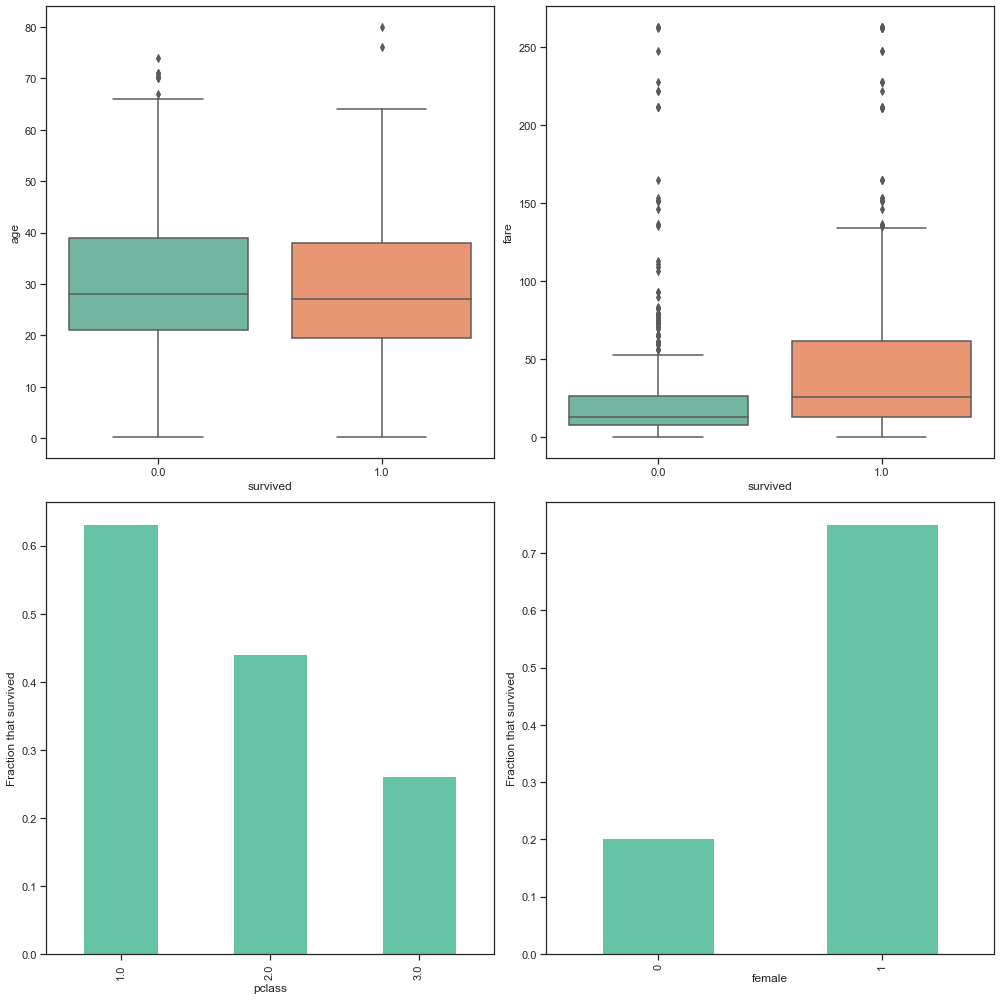

In [29]:
# Names of different columns
categorical_cols = ["pclass", "female"]
continuous_cols = ["age", "fare"]
target_col = "survived"
predictor_cols = categorical_cols + continuous_cols

# This is to plot everything in a 2x2 space
rows, cols = 2, 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

# Plot continous features
for col in continuous_cols:
    sns.boxplot(target_col, col, data=df2, ax=axs[posn])
    axs[posn].set_ylabel(col)
    axs[posn].set_title("")
    posn += 1

# Plot categorical features
for col in categorical_cols:
    df2.groupby(col)[target_col].mean().plot(kind="bar", ax=axs[posn])
    axs[posn].set_ylabel("Fraction that survived")
    posn += 1
    
plt.tight_layout()

This now begs the question: what feature gives the most effective split? 

In [30]:
def best_split(df, info_columns, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    maximum_column = ""
    
    for info_column in info_columns:
        thresh, ig = best_threshold(df, info_column, target_column, criteria)
        
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = thresh
            maximum_column = info_column

    return maximum_column, maximum_threshold, maximum_ig

max_col, max_threshold, max_ig = best_split(df2, predictor_cols, "survived")

print ("The best column to split on is %s giving us a IG of %.4f using a thresh of %.2f" % (max_col, max_ig, max_threshold))

The best column to split on is female giving us a IG of 0.2164 using a thresh of 0.00


### The Classifier Tree: Recursive Splitting

Of course, splitting the data one time sometimes isn't enough to make accurate categorical predictions. However, we can continue to split the data recursively, building a tree-structured model that may give better results. This recursive splitting is the basis for a "decision tree classifier" or "classifier tree", a popular and powerful class of machine learning algorithm. In particular, this specific algorithm is known as ID3 for Iterative Dichotomizer. 

What are some other ways you might consider splitting the data?

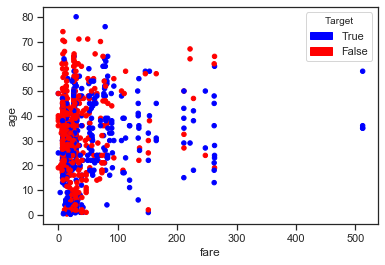

In [31]:
import matplotlib.patches as mpatches

target_col='survive'
cmap = {True: 'blue', False: 'red'}
df.plot(kind="scatter", x="fare", y="age", c=[cmap[c] for c in df[target_col]])
plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc=1, title="Target", frameon=True)
plt.show()

### Decision Tree Classifier

Rather than build a classifier tree from scratch let's use sklearn's implementation which includes some additional functionality.

In [33]:
from sklearn.model_selection import train_test_split

# Names of different columns
categorical_cols = ["pclass", "female"]
continuous_cols = ["age", "fare"]
target_col = "survived"
predictor_cols = categorical_cols + continuous_cols

X=df2[predictor_cols]
y=df2[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("Population:\n",y.value_counts())
print("Train:\n", y_train.value_counts())
print("Test:\n", y_test.value_counts())

Population:
 0.0    618
1.0    423
Name: survived, dtype: int64
Train:
 0.0    453
1.0    327
Name: survived, dtype: int64
Test:
 0.0    165
1.0     96
Name: survived, dtype: int64


In [34]:
df = pd.concat([df,pd.get_dummies(df['sex'], prefix='sex')],axis=1)
df.head()

,survived,pclass,sex,age,fare,survive,sex_female,sex_male,sex_female,sex_male
0,1.0,1.0,female,29.0000,211.3375,True,1,0,1,0
1,1.0,1.0,male,0.9167,151.5500,True,0,1,0,1
2,0.0,1.0,female,2.0000,151.5500,False,1,0,1,0
3,0.0,1.0,male,30.0000,151.5500,False,0,1,0,1
4,0.0,1.0,female,25.0000,151.5500,False,1,0,1,0


What happens when we use df?

In [36]:
from sklearn.tree import DecisionTreeClassifier

# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")   # Look at those 2 arguments !!! 

# Let's tell the model what is the data
#decision_tree.fit(df[["age", "fare","sex","pclass"]], df.survive)

decision_tree.fit(df[["age", "fare","sex_female","pclass"]], df.survive)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

How about __df2__?

In [37]:
from sklearn.tree import DecisionTreeClassifier

# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")   # Look at those 2 arguments !!! 

# Let's tell the model what is the data
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

We now have a classifier tree, let's visualize the results!

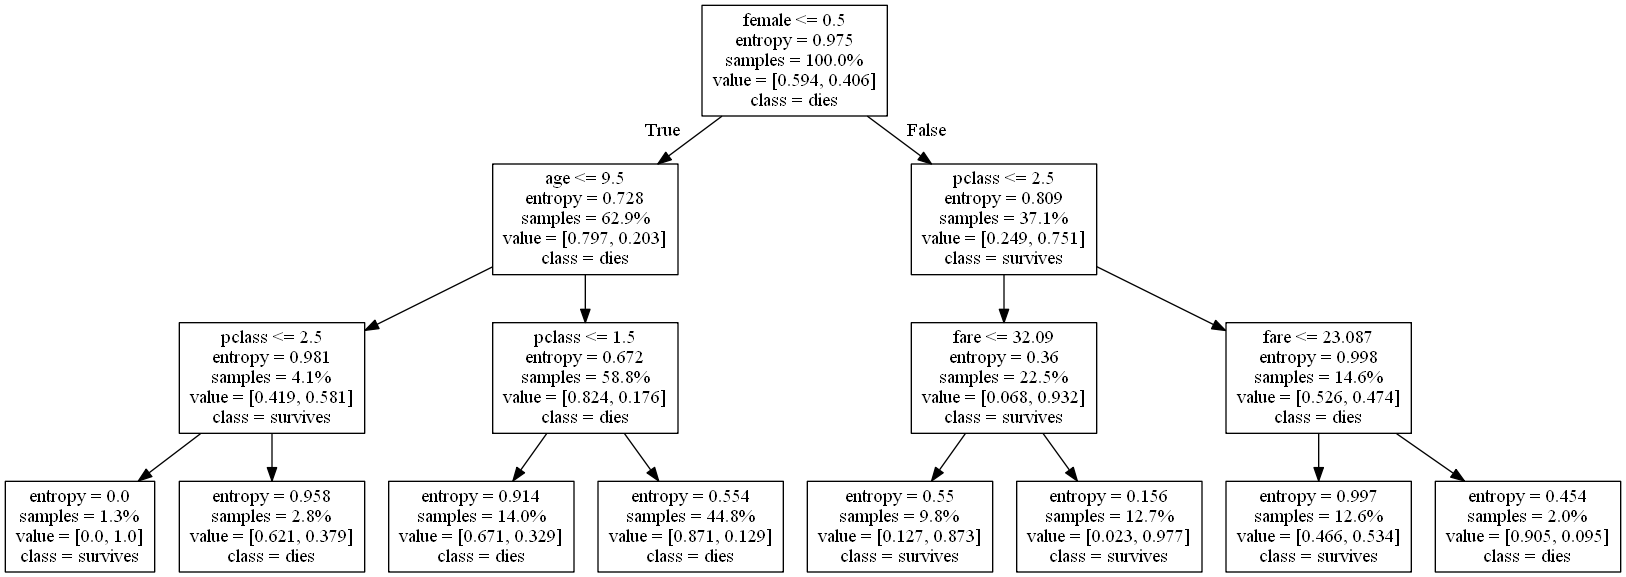

In [38]:
from IPython.display import Image
from sklearn.tree import export_graphviz

def visualize_tree(decision_tree, feature_names, class_names, directory="./images", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)

visualize_tree(decision_tree, predictor_cols, ["dies", "survives"])

### Confusion Matrix & Accuracy

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report

print(y_test.value_counts())

# Make predictions against the test set
pred = decision_tree.predict(X_test)

# Show the confusion matrix
''' confusion matrix returned with Predicted as the Columns and Actual as the Rows
         PN  PP
     AN [tn  fp] 
     AP [fn  tp]
'''
print("confusion matrix:")
print(confusion_matrix(y_test, pred))
tn,fp,fn,tp=confusion_matrix(y_test, pred).ravel()
print('tn: ',tn)
print('fp: ',fp)
print('fn: ',fn)
print('tp: ',tp)

# Find the accuracy scores of the predictions against the true classes
print("accuracy: %0.3f" % accuracy_score(y_test, pred))
print("recall: %0.3f" % recall_score(y_test, pred))
print("precision: %0.3f" % precision_score(y_test, pred))
print("f-measure: %0.3f" % fbeta_score(y_test, pred, beta=1))
print(classification_report(y_test,pred))

0.0    165
1.0     96
Name: survived, dtype: int64
confusion matrix:
[[142  23]
 [ 25  71]]
tn:  142
fp:  23
fn:  25
tp:  71
accuracy: 0.816
recall: 0.740
precision: 0.755
f-measure: 0.747
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86       165
         1.0       0.76      0.74      0.75        96

    accuracy                           0.82       261
   macro avg       0.80      0.80      0.80       261
weighted avg       0.82      0.82      0.82       261



In [44]:
# you may need to run this to update to scikit-learn version 0.22.1
!pip install -U scikit-learn --user

Requirement already up-to-date: scikit-learn in /Users/lukedunscombe/.local/lib/python3.7/site-packages (0.22.1)


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

negative_label='Not Survive'
positive_label='Survive'

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(decision_tree, X_test, y_test,
                                 display_labels=[negative_label,positive_label],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    disp.ax_.set_xlabel('Predicted')
    disp.ax_.set_ylabel('Actual')

    print(title)
    print(disp.confusion_matrix)

plt.show()

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

### Cross Validation 

It is important to keep in mind that cross-validation is not a way to build a model that can be applied to new data. Cross-validation does not return a model. When calling cross_val_score, multiple models are built internally, but the purpose of cross-validation is only to evaluate how well a given algorithm will generalize when trained on a specific dataset.

- Introduction to Machine Learning with Python (http://shop.oreilly.com/product/0636920030515.do)

#### Cross_val_score

Evaluate a model by score using cross-validation

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")

scores = cross_val_score(decision_tree, X, y, cv=10)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))


Cross-validation scores: [0.48571429 0.86666667 0.86666667 0.82692308 0.84615385 0.84615385
 0.89423077 0.67307692 0.66990291 0.59223301]
Average cross-validation score: 0.76


You can change the scoring parameter to utilize a different score
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")

scores = cross_val_score(decision_tree, X, y, cv=10, scoring='recall')
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.97674419 0.72093023 0.79069767 0.66666667 0.88095238 0.85714286
 0.9047619  0.52380952 0.5        0.        ]
Average cross-validation score: 0.68


#### Cross_validate 

Evaluate metric(s) by cross-validation and also record fit/score times.

In [25]:
from sklearn.model_selection import cross_validate
result = cross_validate(decision_tree, X, y, cv=10, return_train_score=True)
print("Mean times and scores:\n", pd.DataFrame(result).mean())

Mean times and scores:
 fit_time       0.002911
score_time     0.001244
test_score     0.756772
train_score    0.810327
dtype: float64
